Epoch 1/50 Discriminator Loss: 1.2412, Generator Loss: 0.6758
Epoch 6/50 Discriminator Loss: 0.9942, Generator Loss: 1.0205
Epoch 11/50 Discriminator Loss: 0.7162, Generator Loss: 1.2418
Epoch 16/50 Discriminator Loss: 0.5236, Generator Loss: 1.6046
Epoch 21/50 Discriminator Loss: 0.5669, Generator Loss: 1.5810
Epoch 26/50 Discriminator Loss: 0.3630, Generator Loss: 1.7017
Epoch 31/50 Discriminator Loss: 0.4112, Generator Loss: 1.8251
Epoch 36/50 Discriminator Loss: 0.6128, Generator Loss: 1.7477
Epoch 41/50 Discriminator Loss: 0.4863, Generator Loss: 1.8829
Epoch 46/50 Discriminator Loss: 0.5097, Generator Loss: 2.0617
Epoch 50/50 Discriminator Loss: 0.5058, Generator Loss: 2.1889


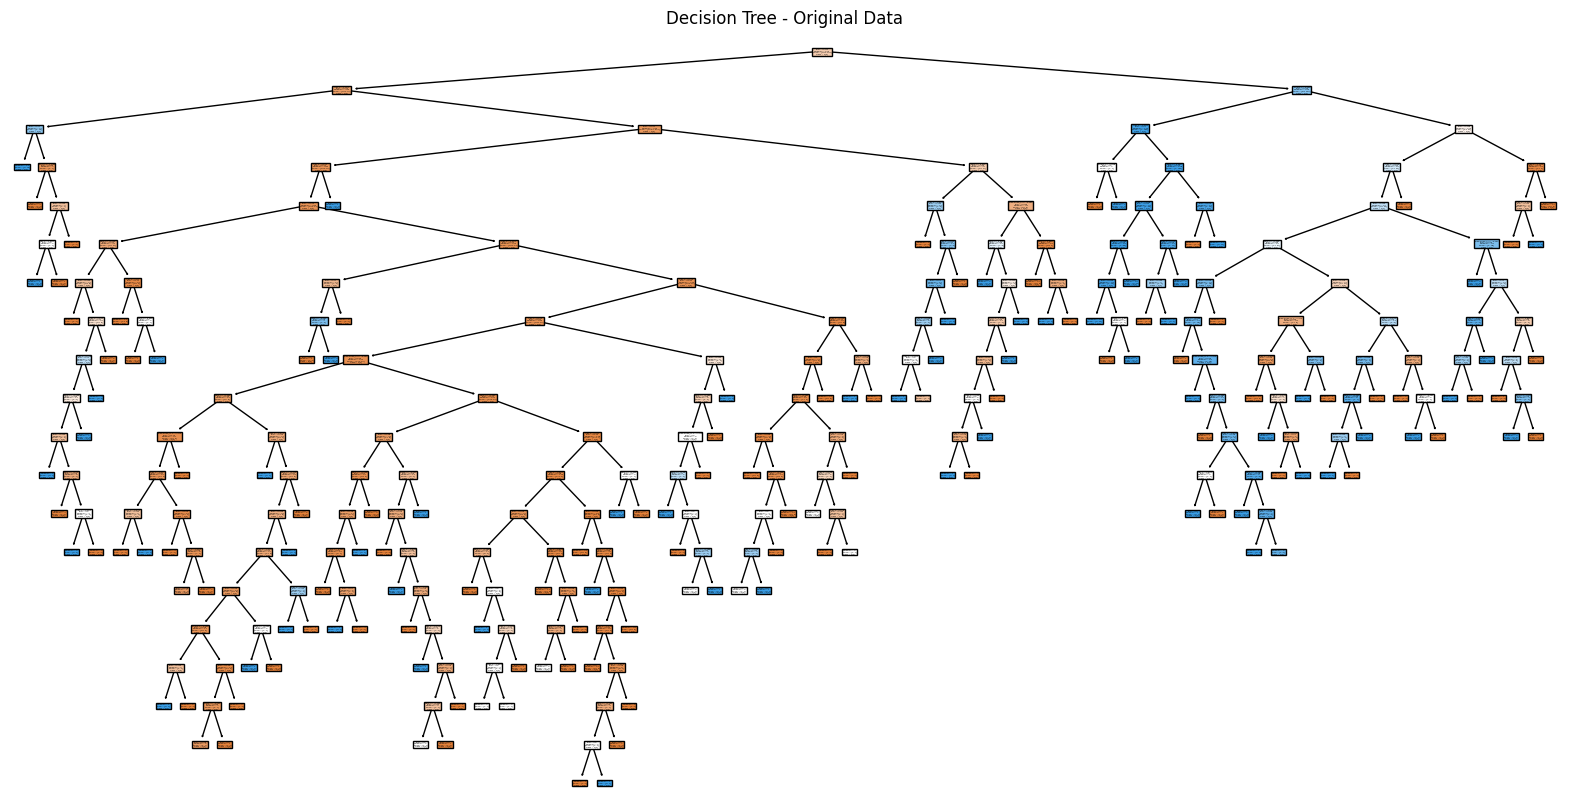

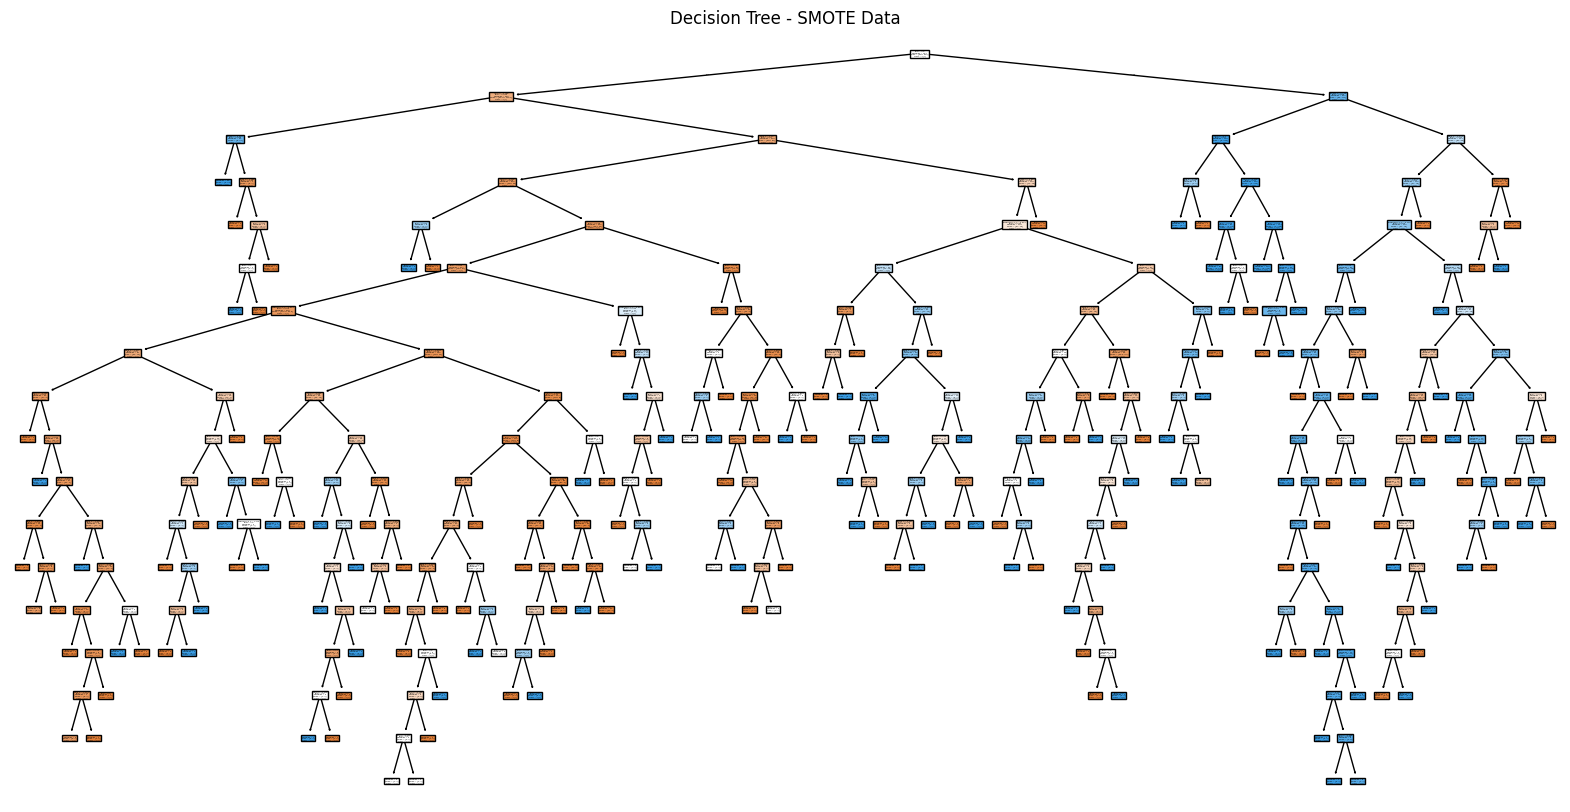

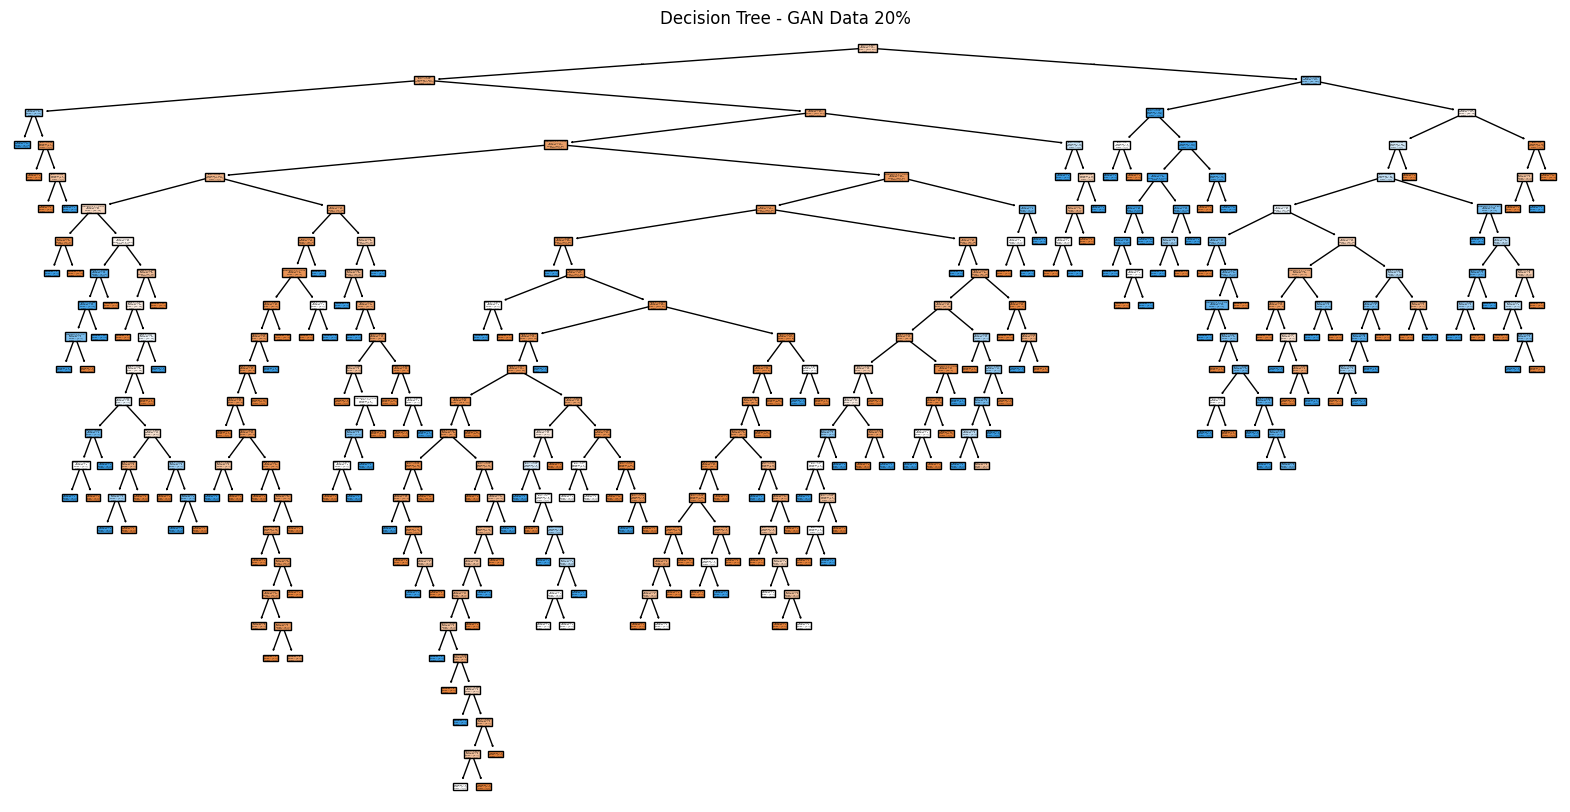

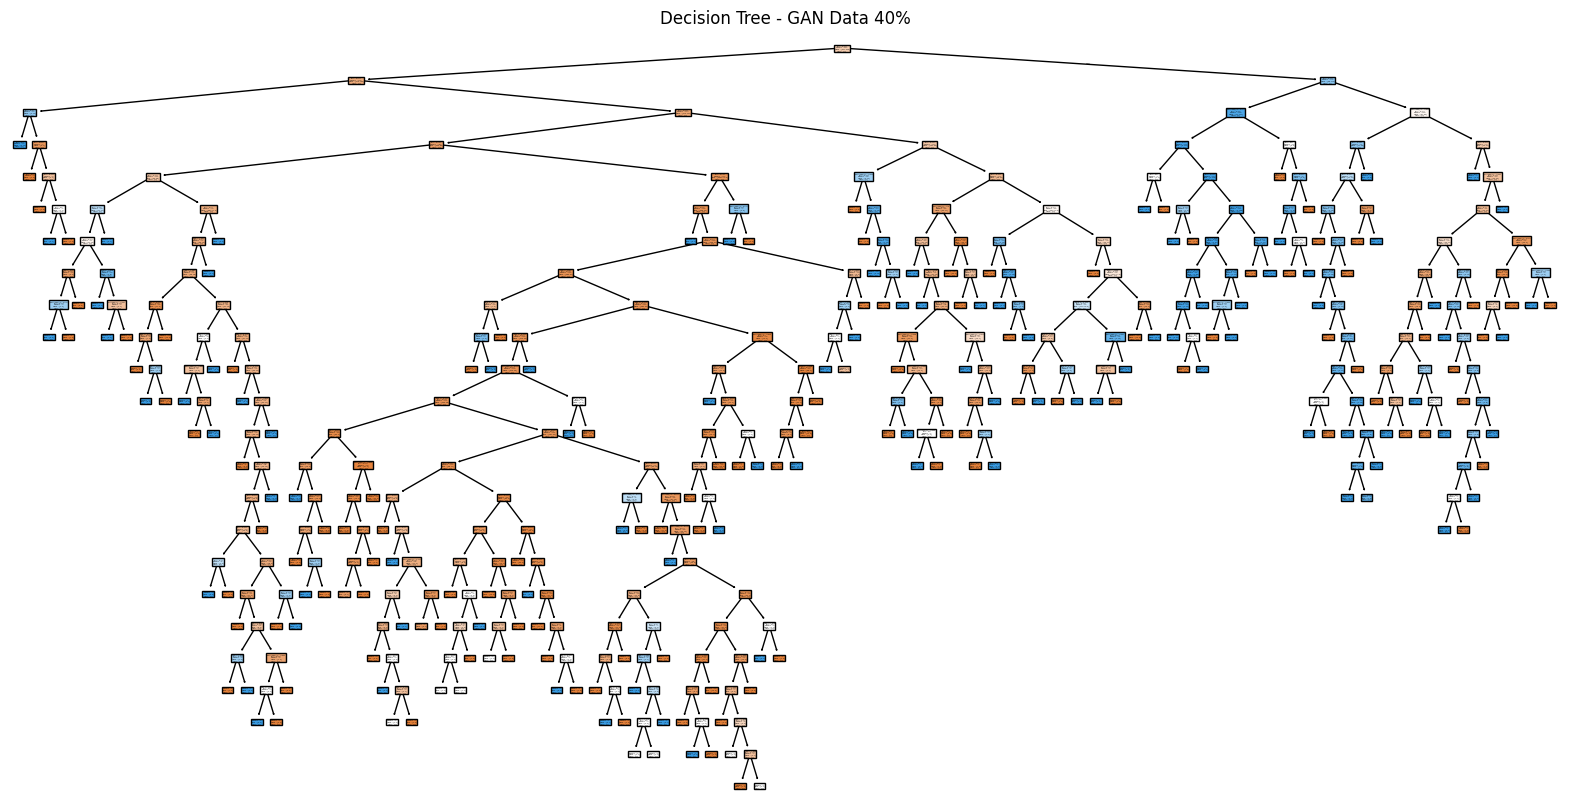

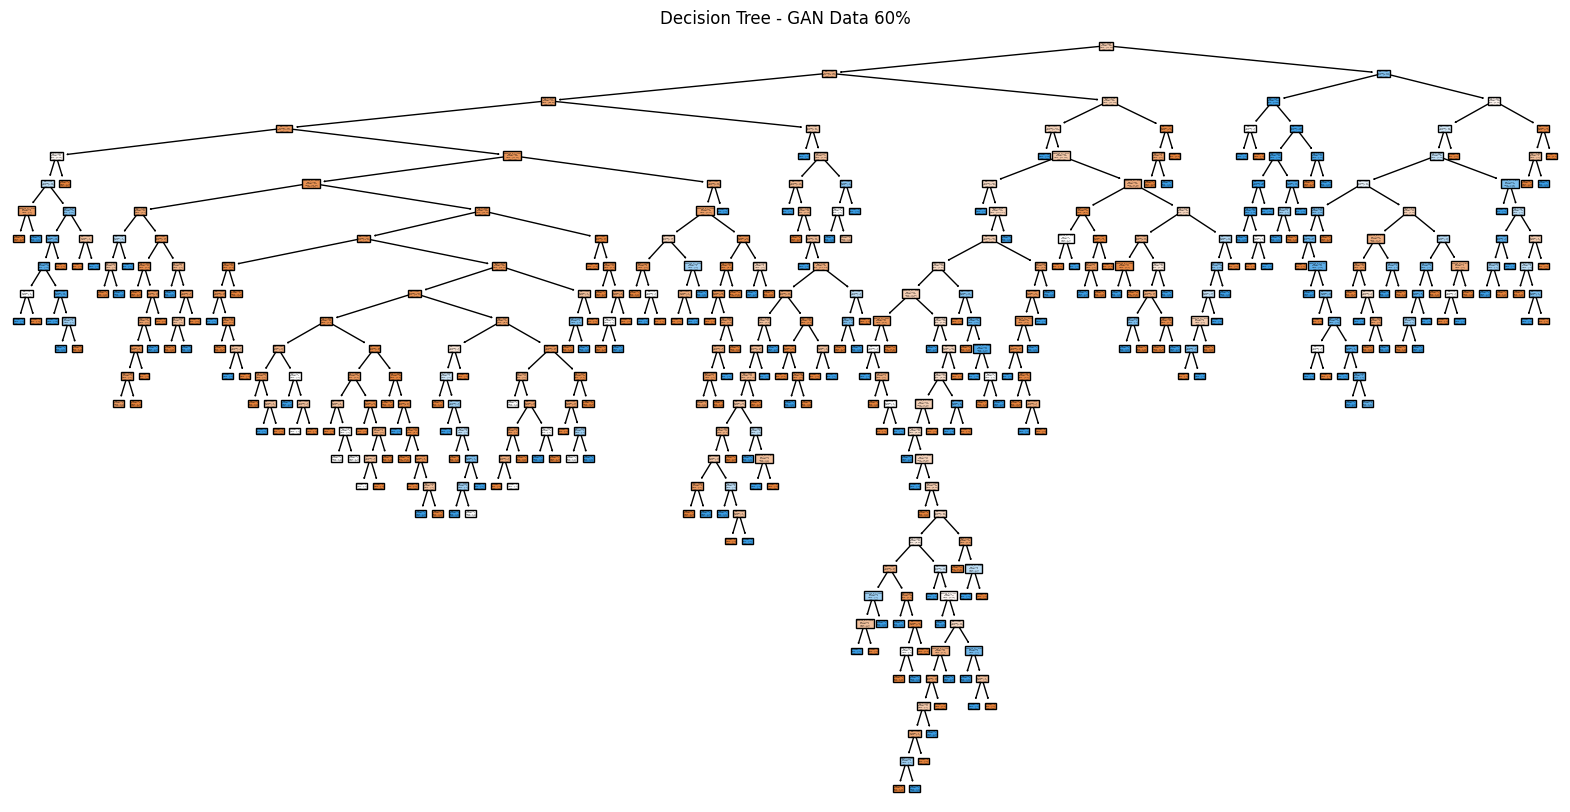

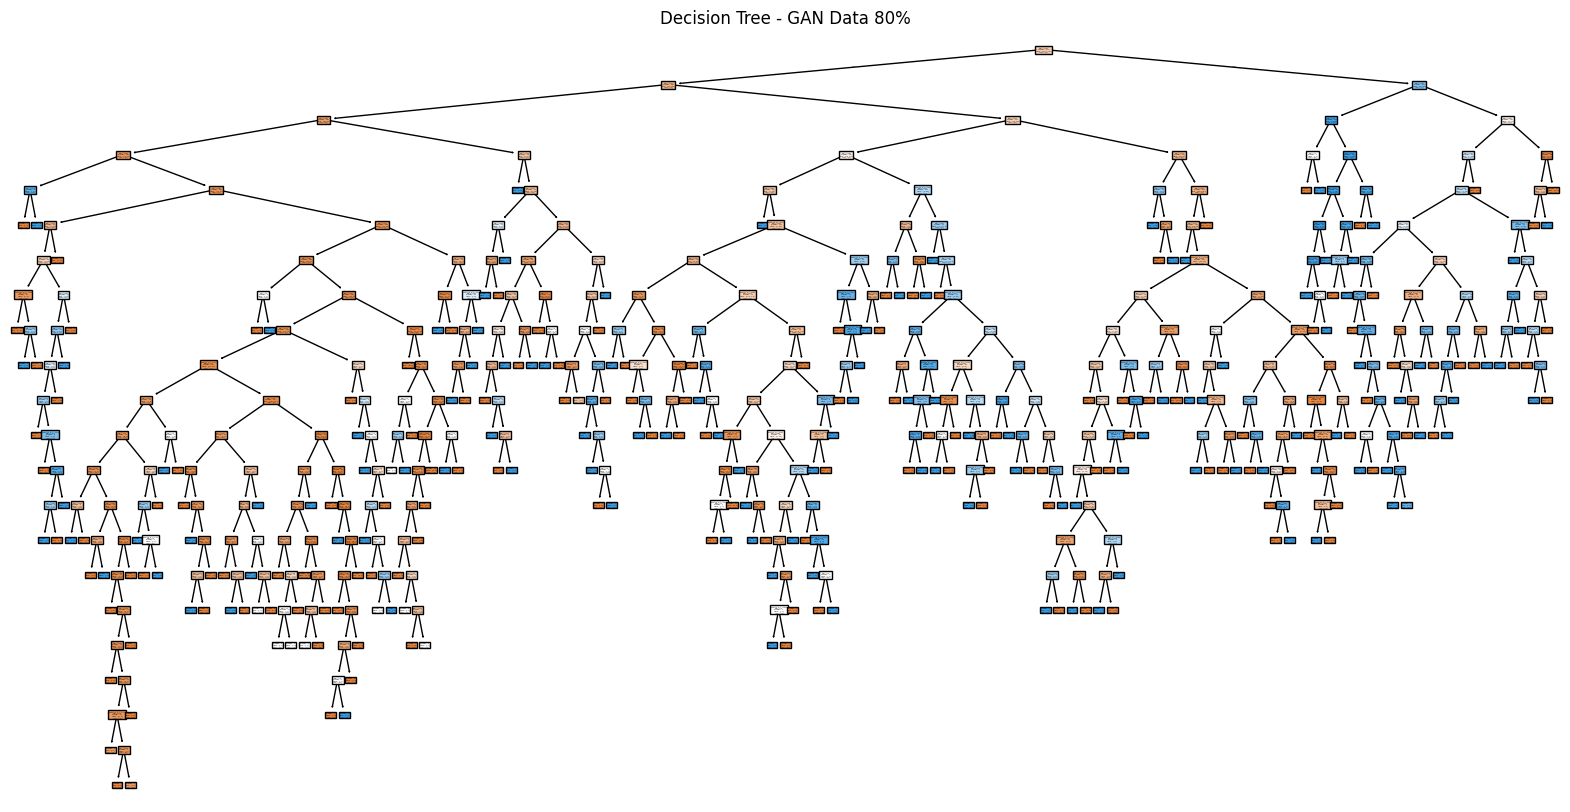

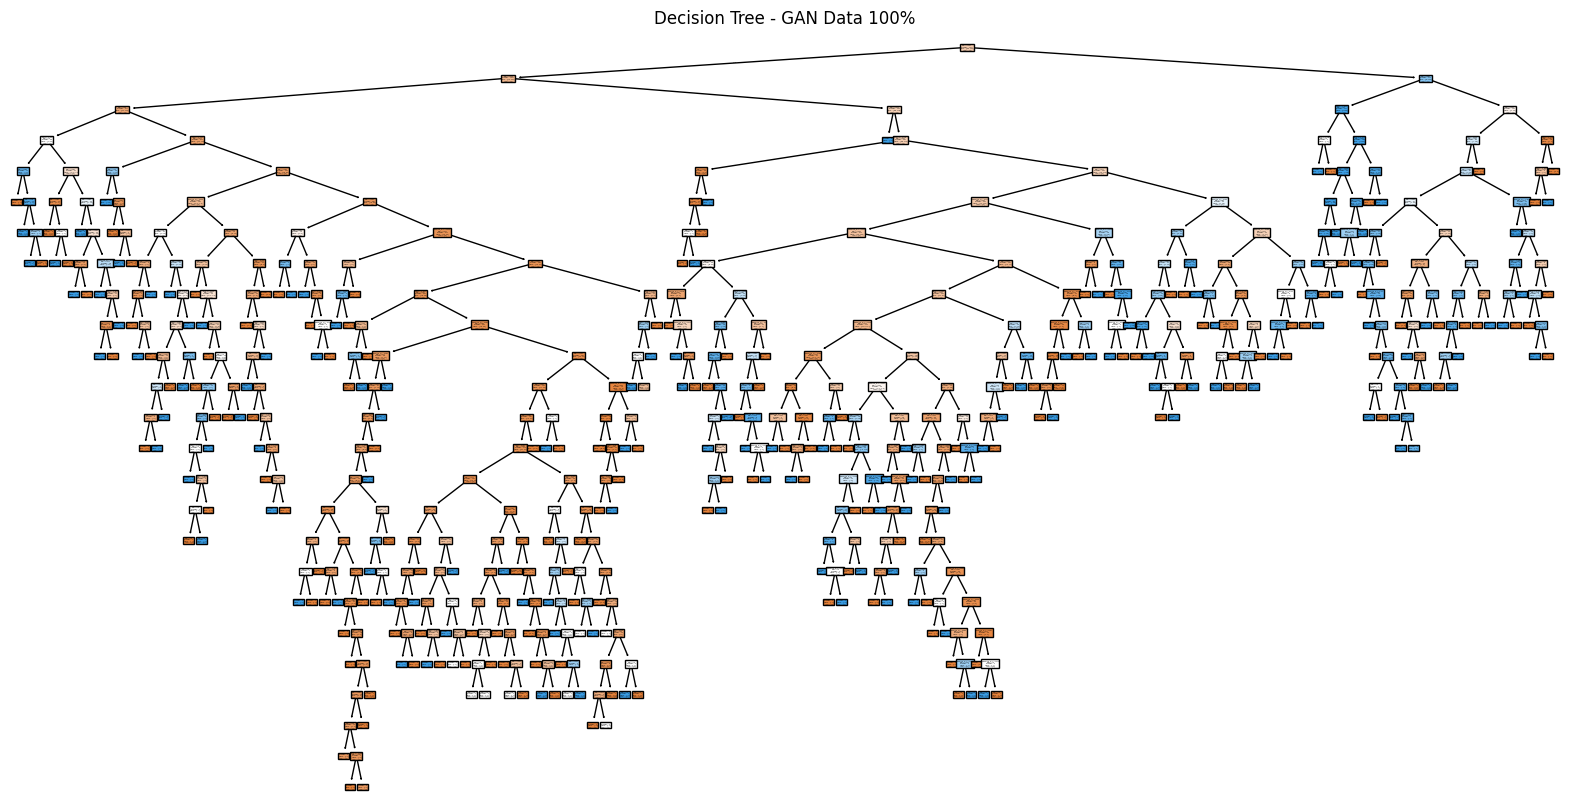

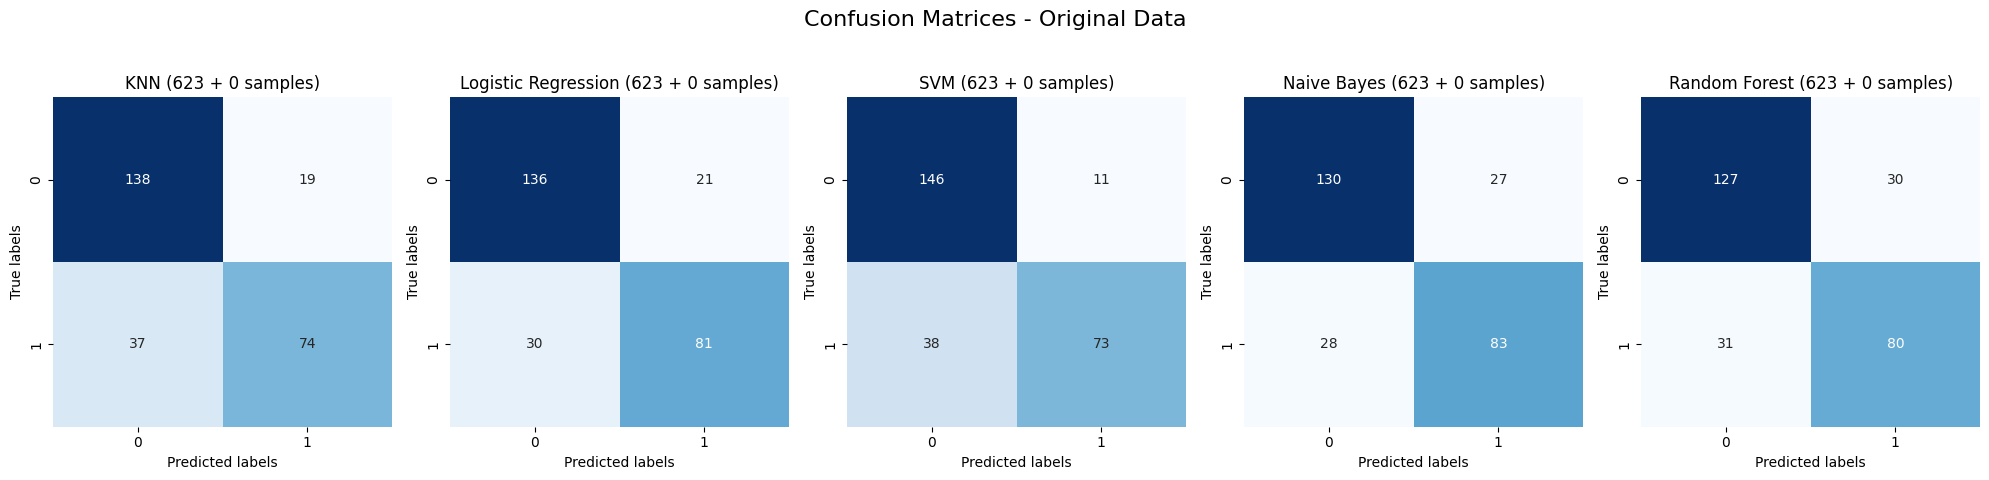

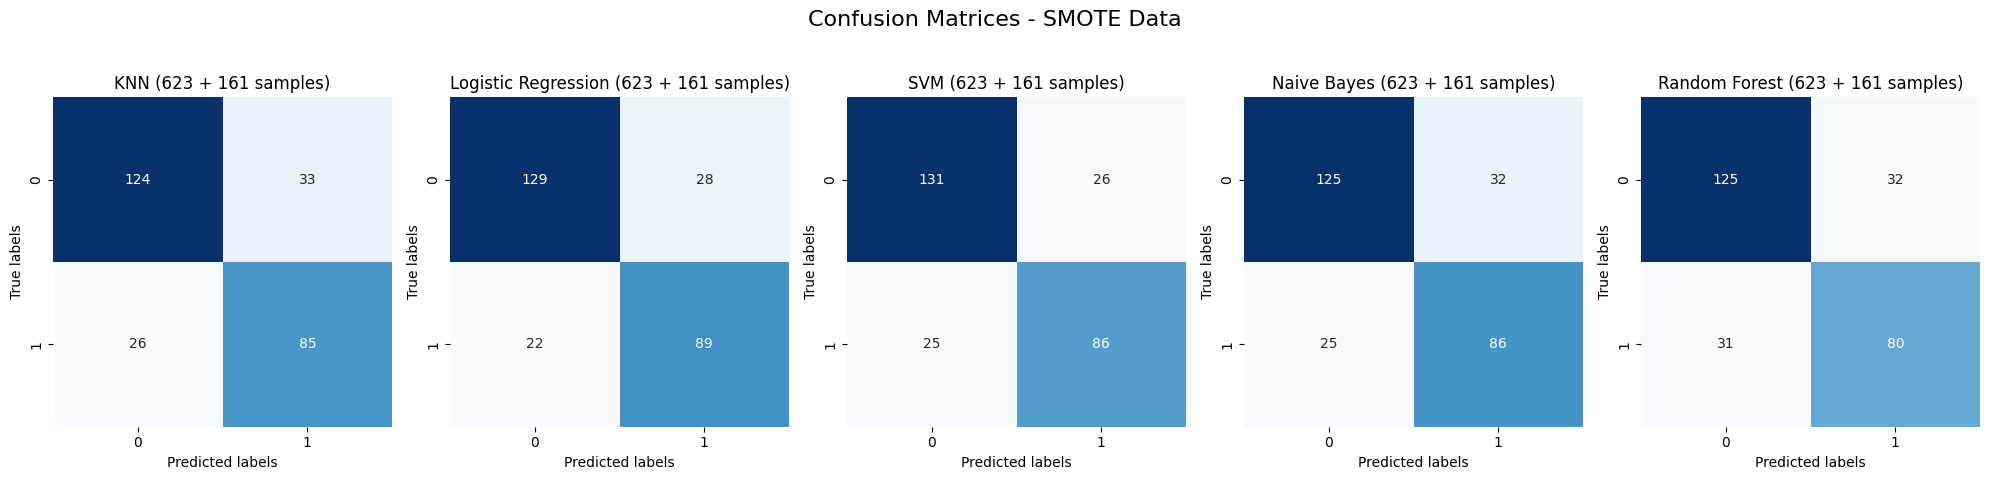

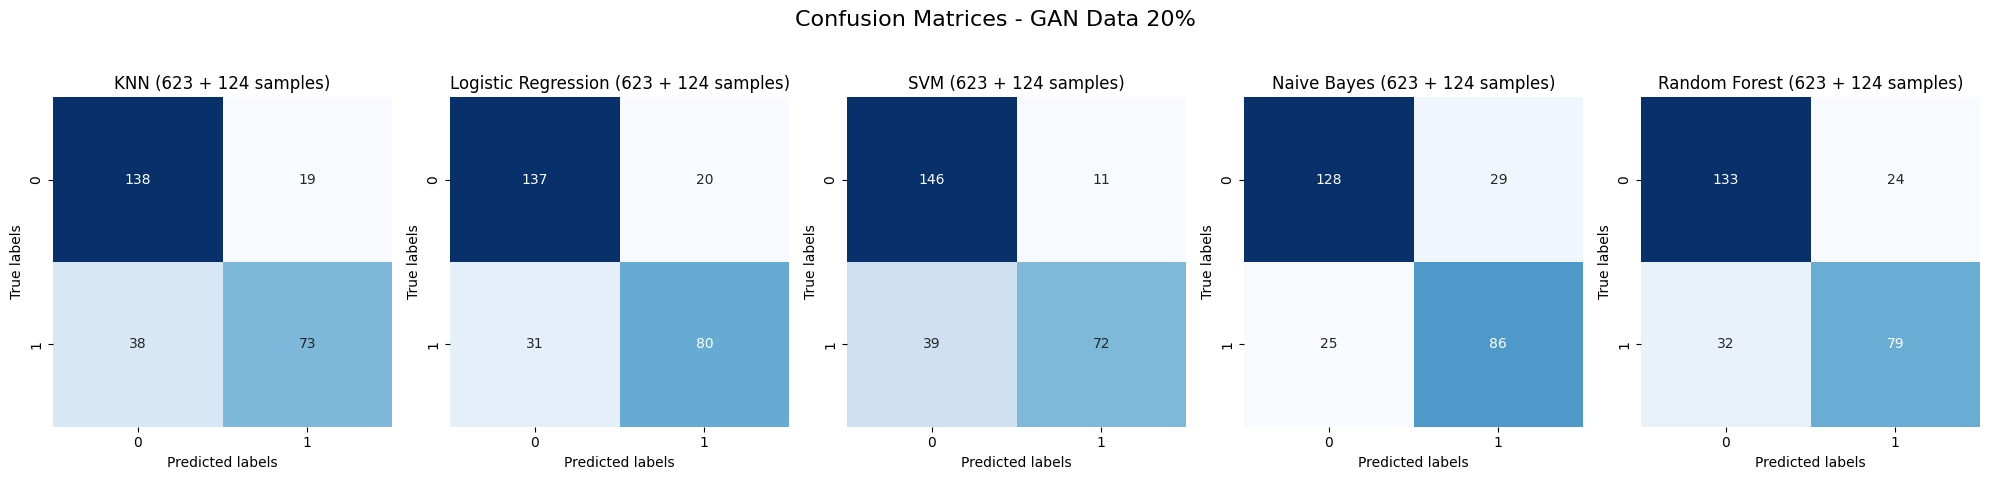

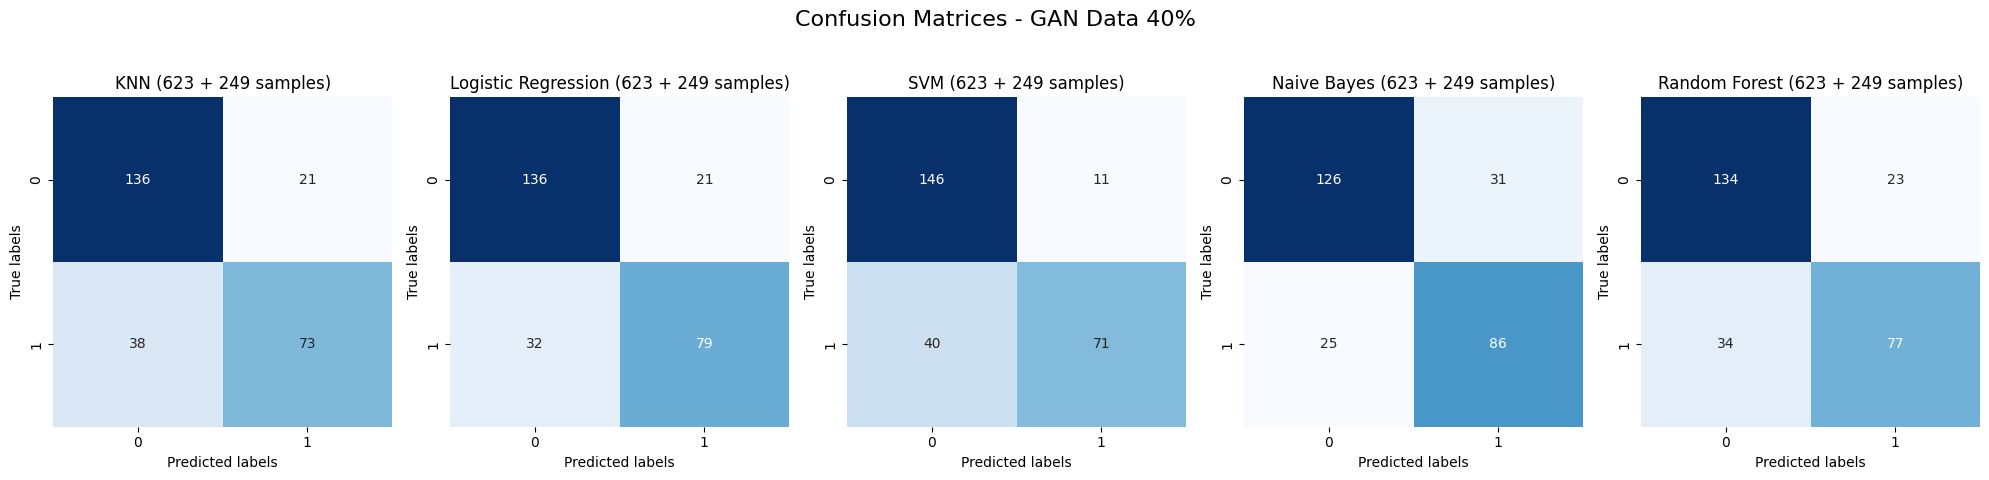

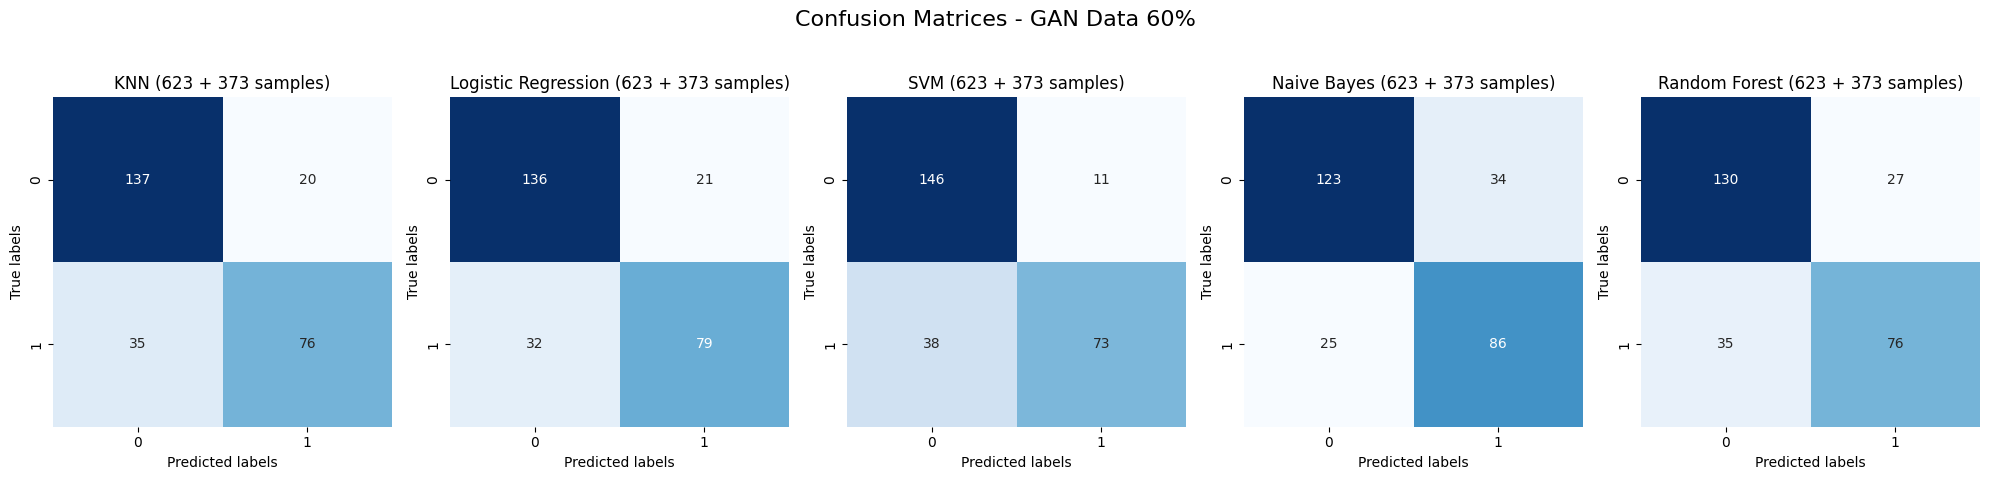

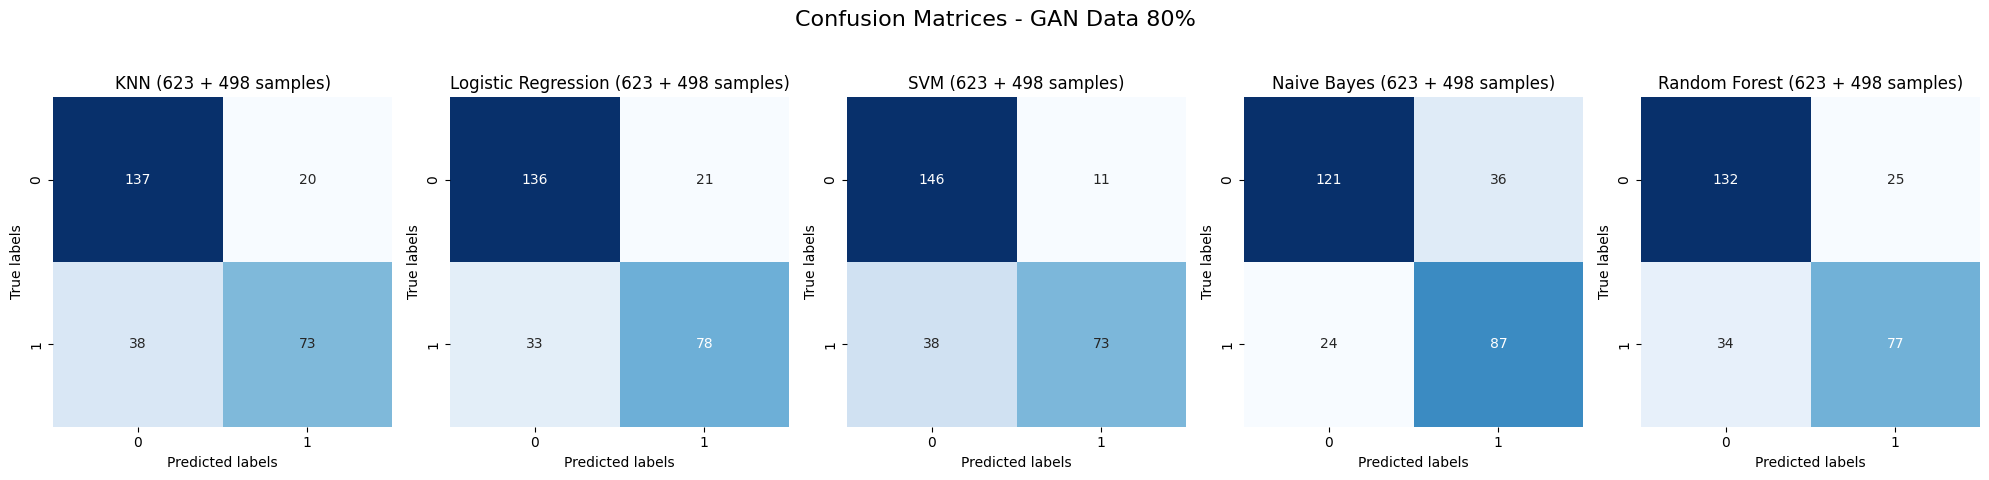

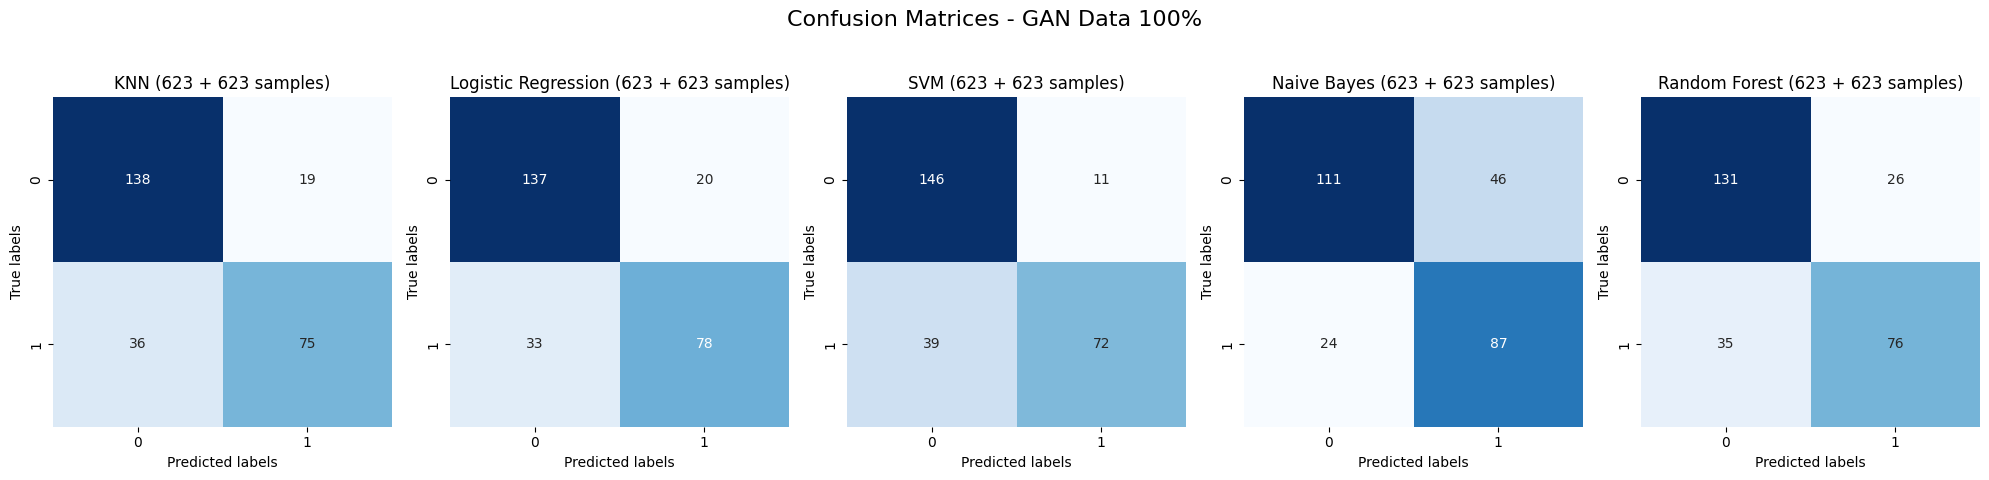


Best Classifier: Logistic Regression
Best ROC AUC: 0.8781
Percentage of Synthetic Samples: 60%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.79      0.71      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

Confusion Matrix:
[[136  21]
 [ 32  79]]


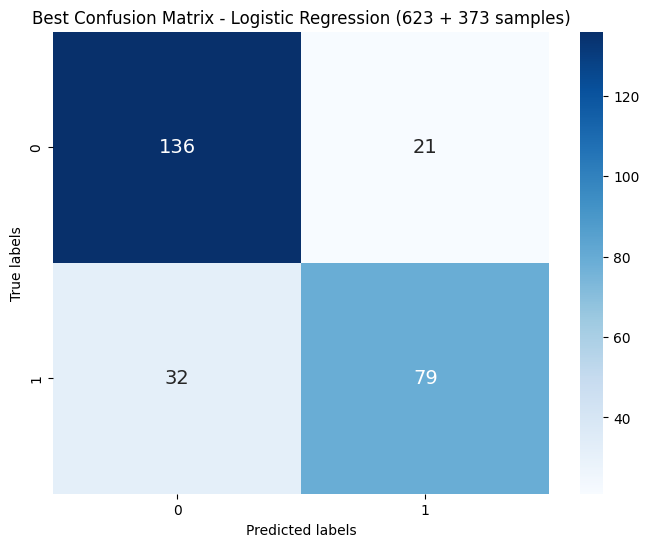

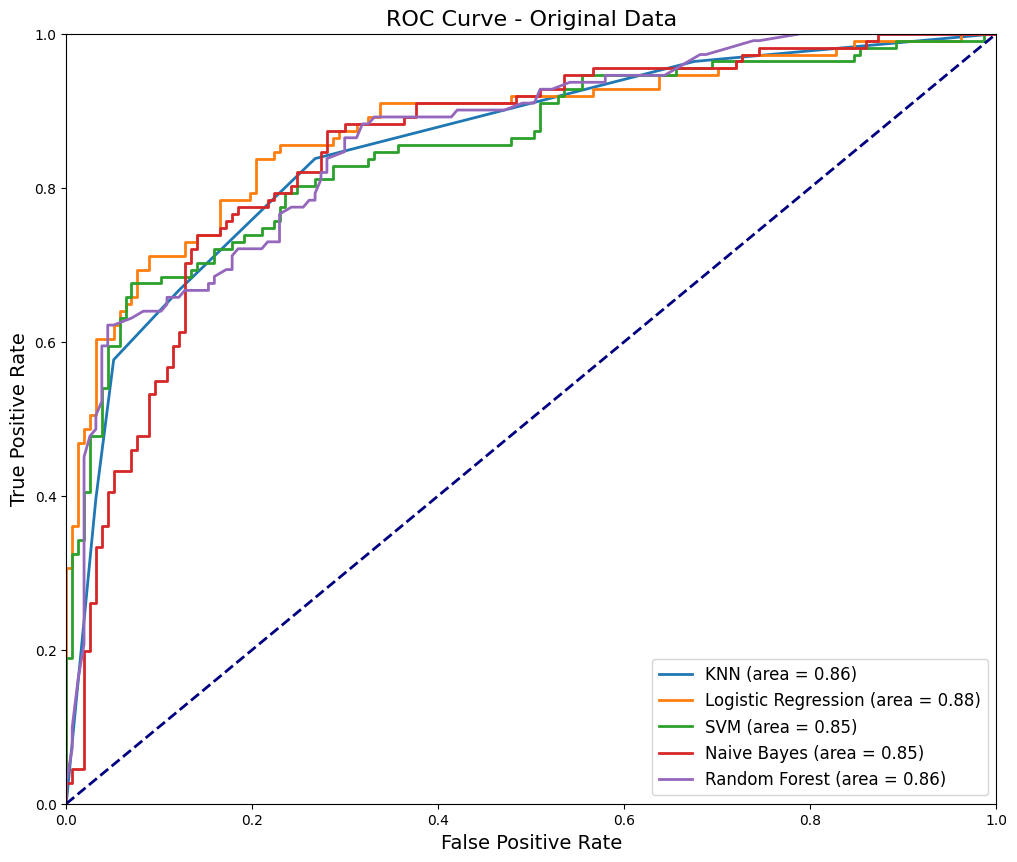

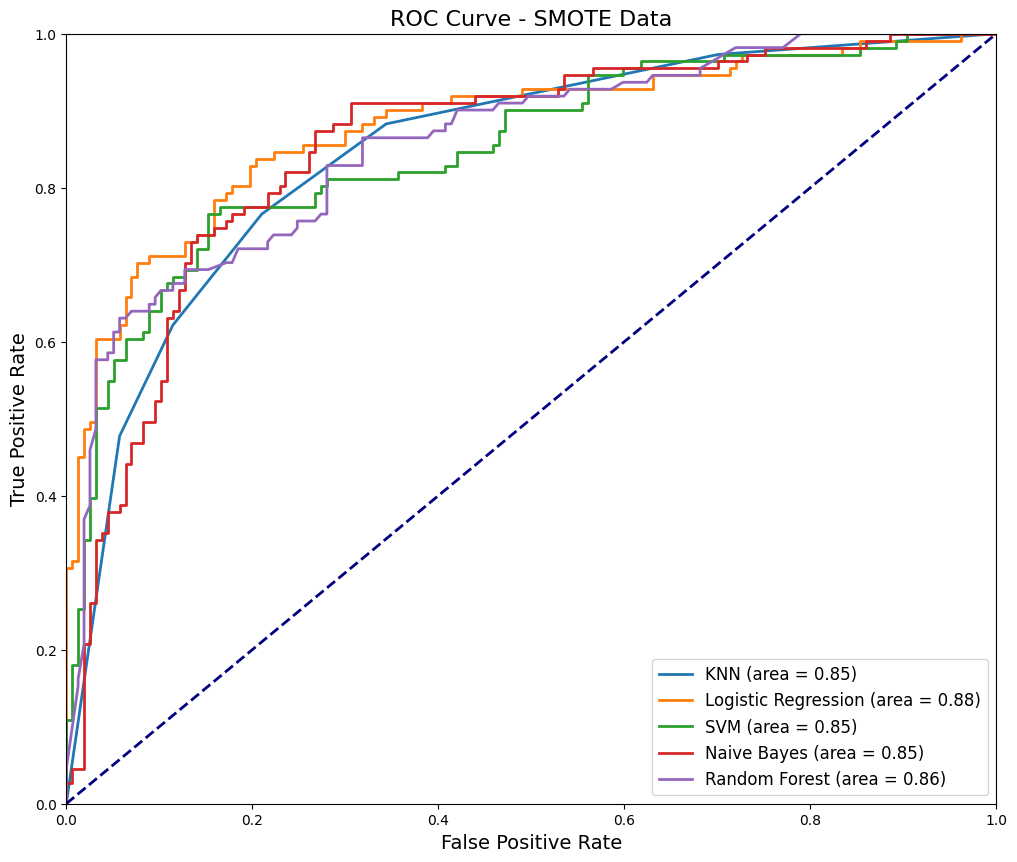

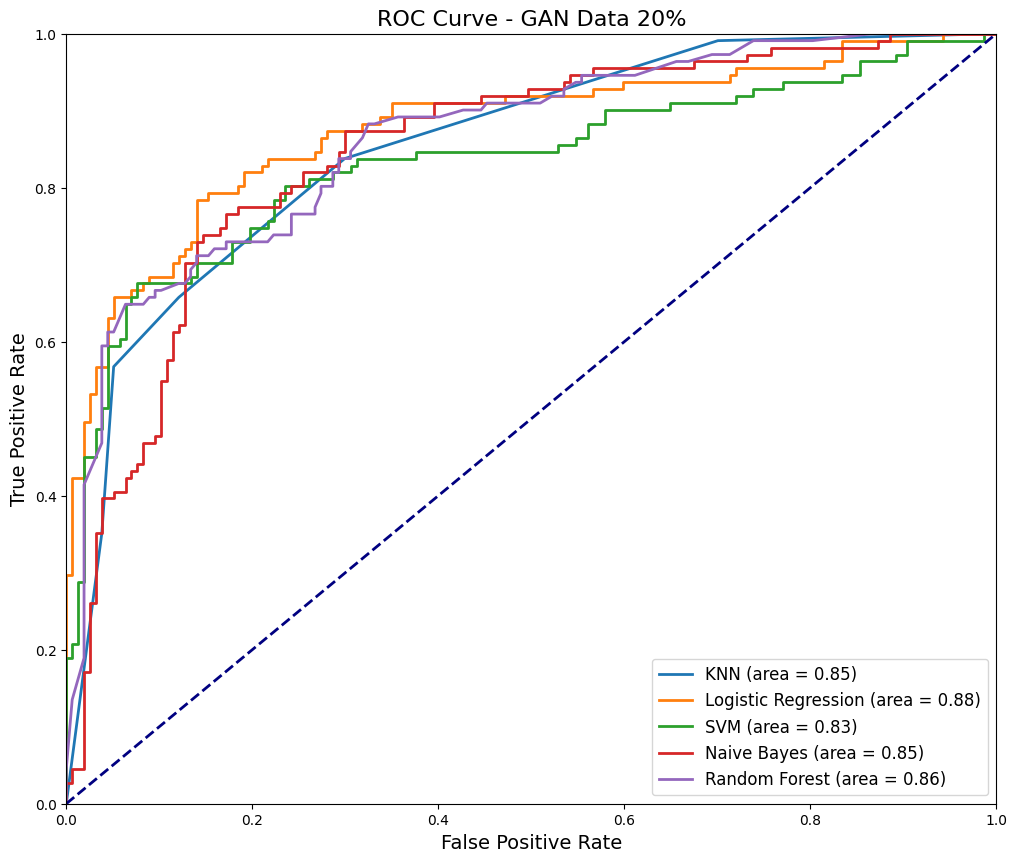

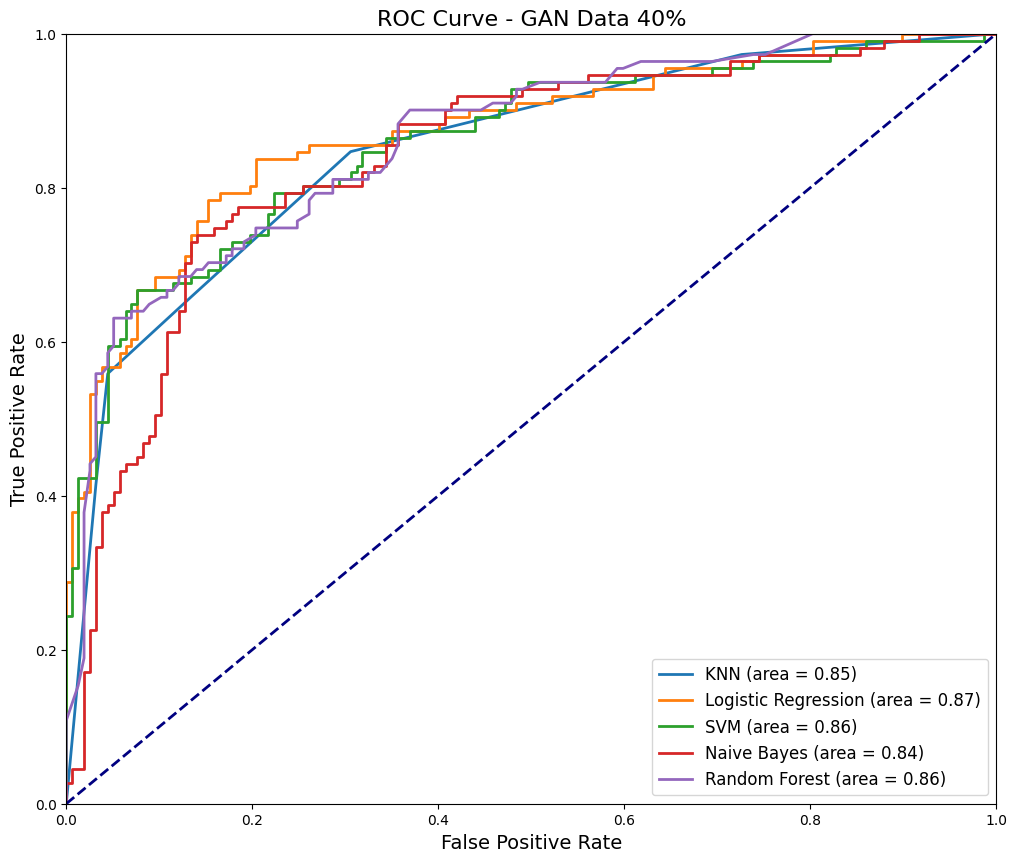

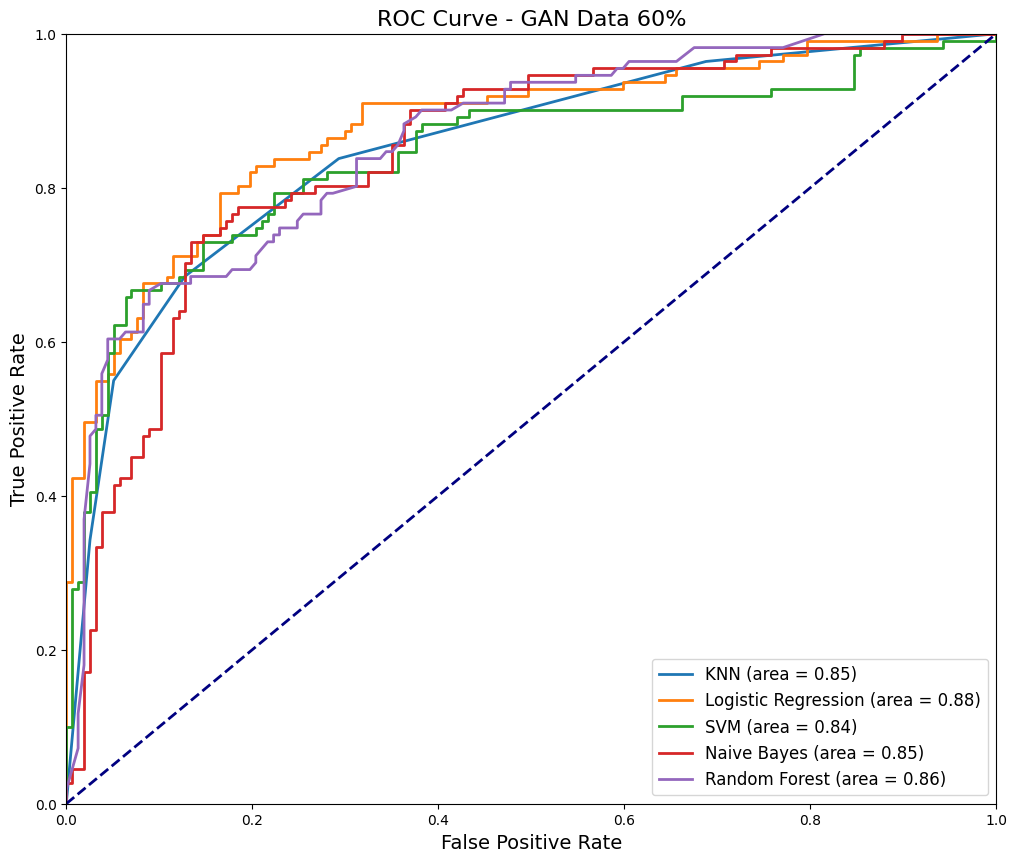

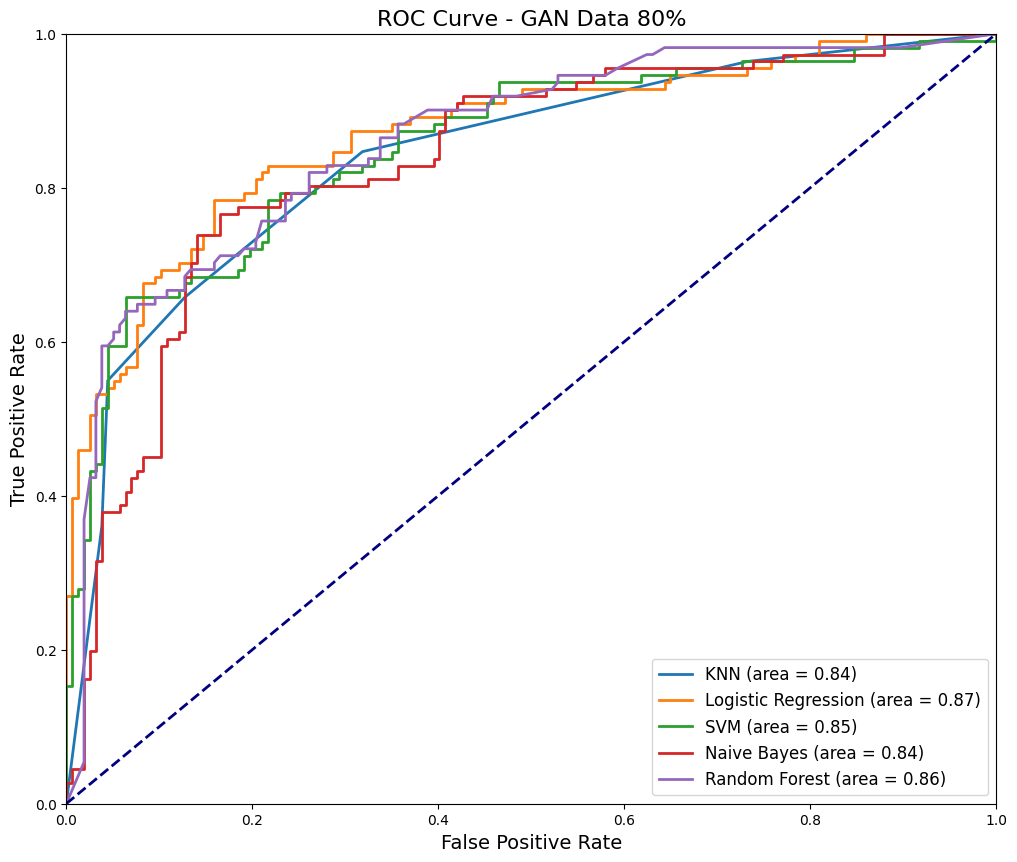

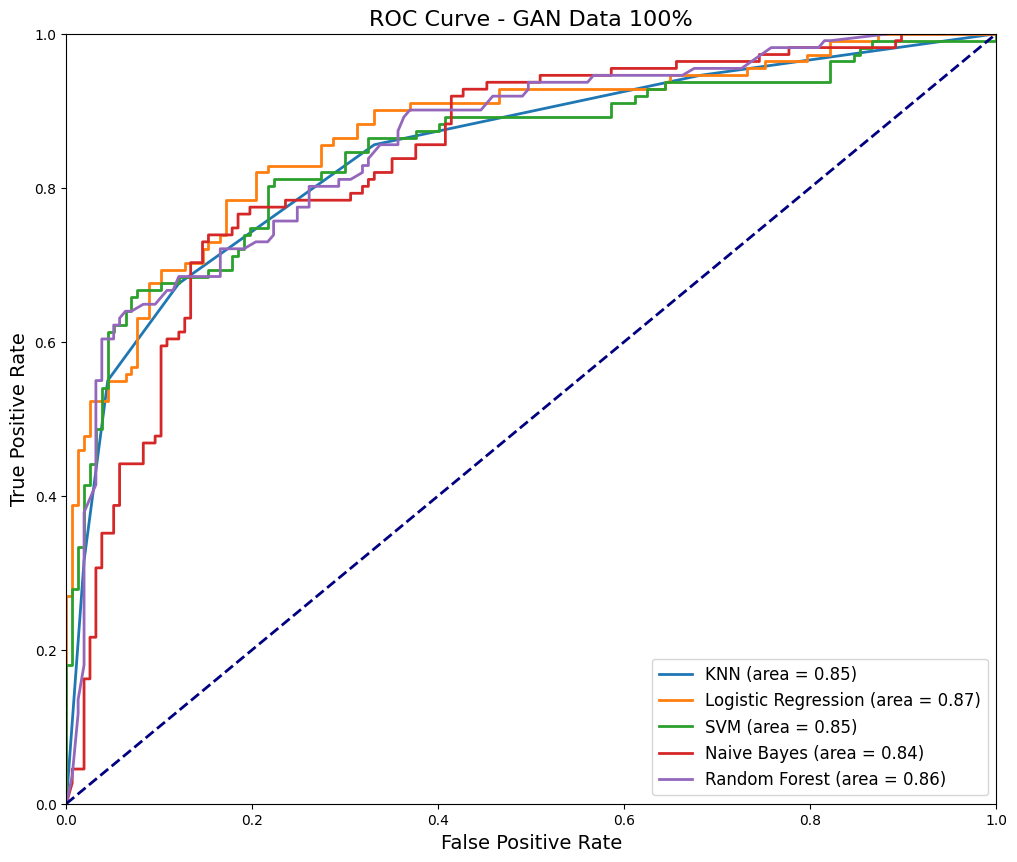

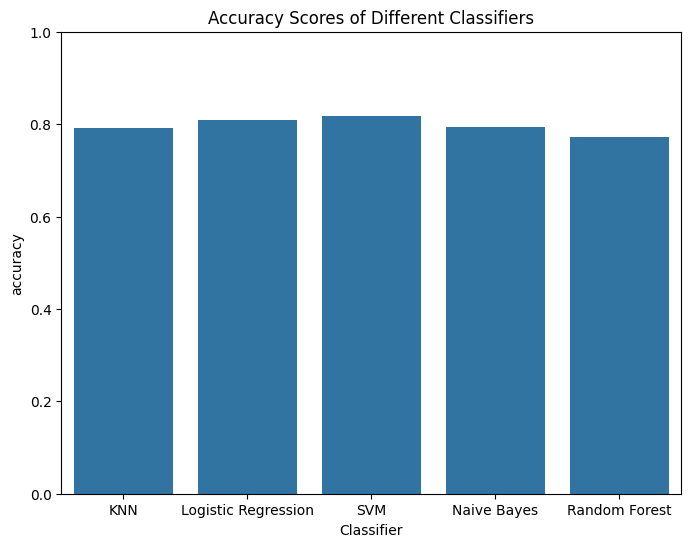

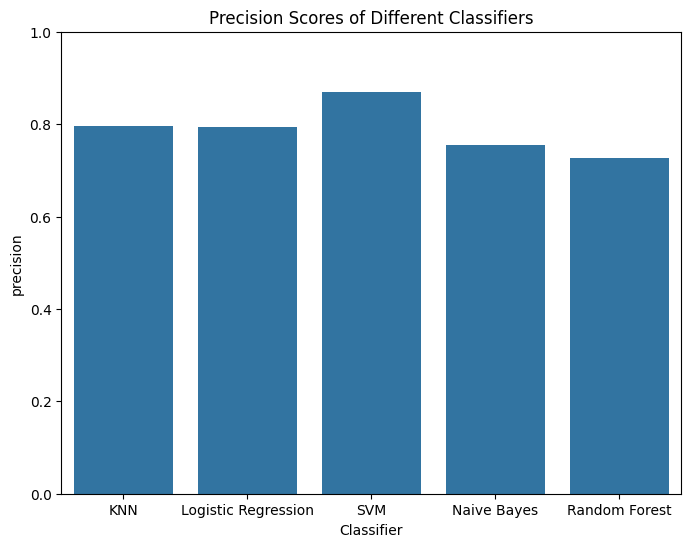

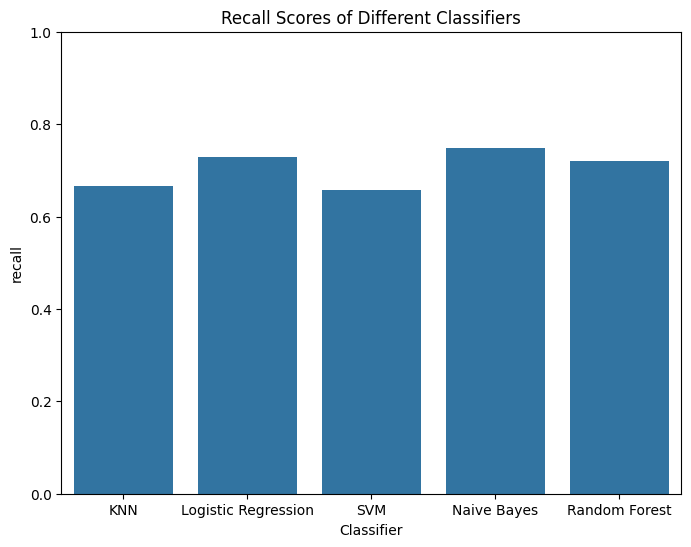

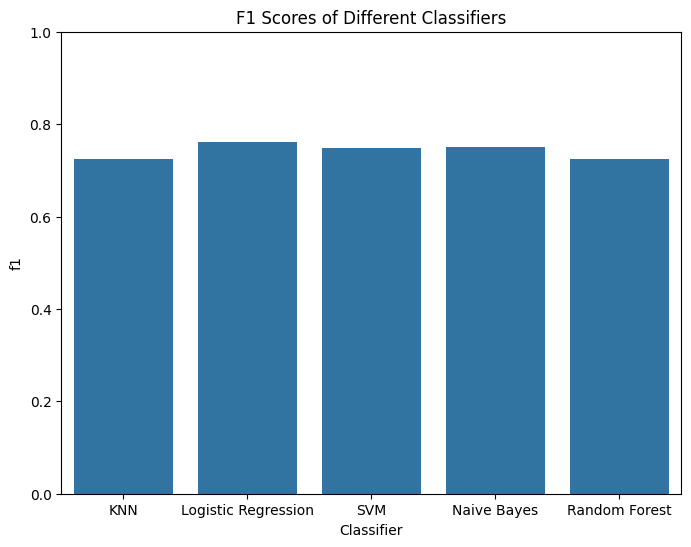

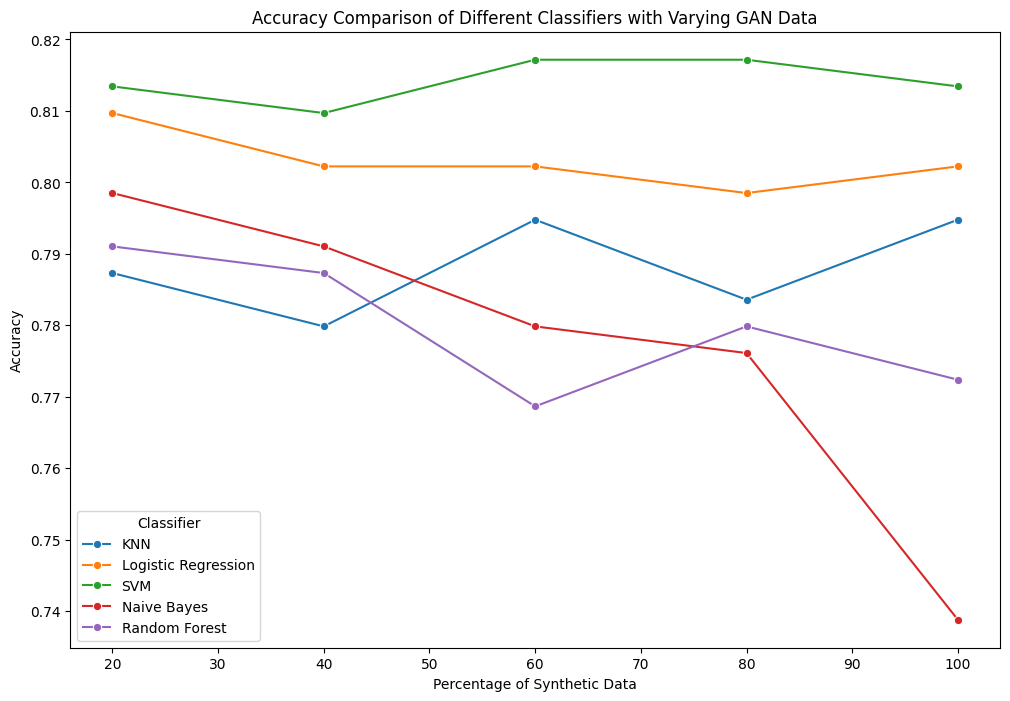

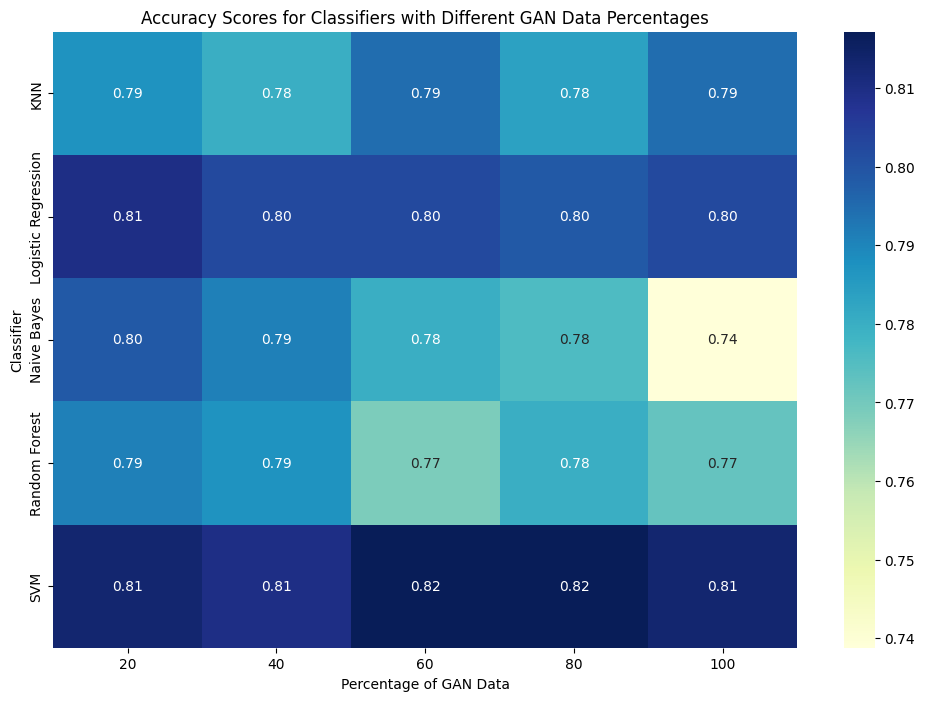

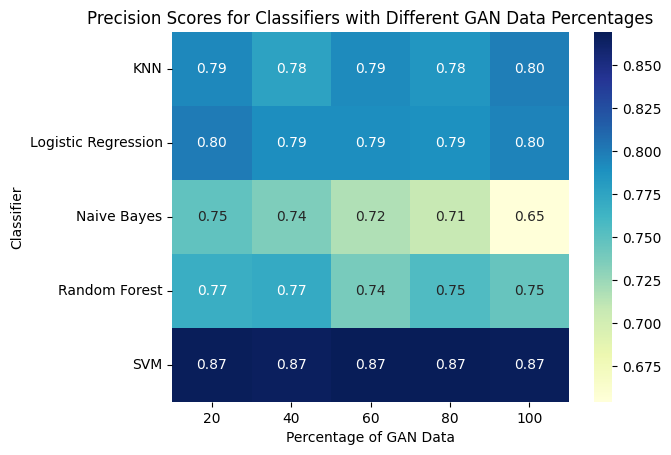

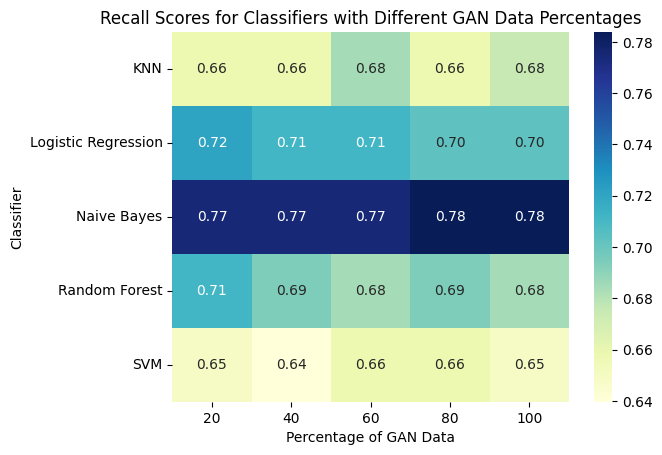

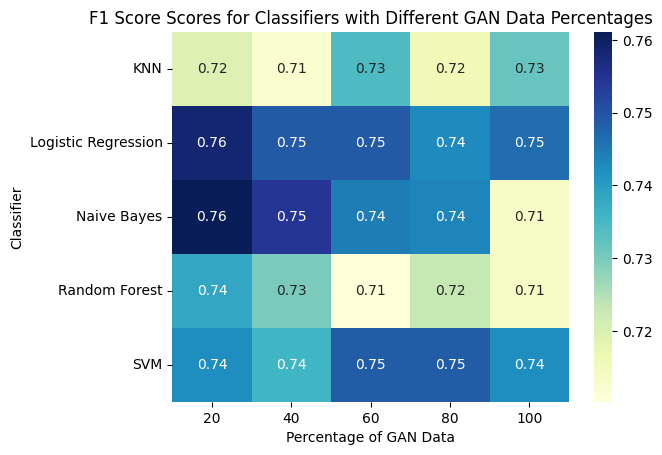

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functions import *

def main():
    dataset_path = "./Titanic-Dataset.csv"
    target_column = 'Survived'
    synthetic_sample_percentages = [20, 40, 60, 80, 100]
    epochs = 50

    data = read_and_clean_data(dataset_path)
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    latent_dim = 100
    output_dim = X_scaled.shape[1]

    generator = Generator(latent_dim, output_dim)
    discriminator = Discriminator(output_dim)

    adversarial_loss = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    train_gan(generator, discriminator, adversarial_loss, optimizer_G, optimizer_D, epochs=epochs, batch_size=32, latent_dim=latent_dim, X_scaled=X_scaled)

    smote = SMOTE(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Evaluate decision tree on original data
    clf_original = evaluate_decision_tree(X_train, y_train)
    plot_decision_tree(clf_original, X.columns, "Decision Tree - Original Data")

    # Evaluate decision tree on SMOTE data
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    clf_smote = evaluate_decision_tree(X_smote, y_smote)
    plot_decision_tree(clf_smote, X.columns, "Decision Tree - SMOTE Data")

    for percent in synthetic_sample_percentages:
        num_synthetic_samples = int((percent / 100) * len(X_train))

        z = torch.randn((num_synthetic_samples, latent_dim), dtype=torch.float)
        X_synthetic = generator(z).detach().numpy()

        X_train_gan_combined = np.vstack((X_train, X_synthetic))
        y_train_gan_combined = np.hstack((y_train, y_train[:num_synthetic_samples]))

        clf_gan_combined = evaluate_decision_tree(X_train_gan_combined, y_train_gan_combined)
        plot_decision_tree(clf_gan_combined, X.columns, f"Decision Tree - GAN Data {percent}%")

    results_original = evaluate_classifiers(X_train, X_test, y_train, y_test)
    results_smote_combined = evaluate_classifiers(X_smote, X_test, y_smote, y_test)

    best_performance = {'roc_auc': 0, 'percent': 0, 'results': None}
    results_all = []

    for percent in synthetic_sample_percentages:
        num_synthetic_samples = int((percent / 100) * len(X_train))

        z = torch.randn((num_synthetic_samples, latent_dim), dtype=torch.float)
        X_synthetic = generator(z).detach().numpy()

        X_train_gan_combined = np.vstack((X_train, X_synthetic))
        y_train_gan_combined = np.hstack((y_train, y_train[:num_synthetic_samples]))

        results_gan_combined = evaluate_classifiers(X_train_gan_combined, X_test, y_train_gan_combined, y_test)

        results_all.append((percent, results_gan_combined))

        for res in results_gan_combined:
            if res["roc_auc"] and res["roc_auc"] > best_performance['roc_auc']:
                best_performance = {'roc_auc': res["roc_auc"], 'percent': percent, 'results': res, 'classifier': res["name"]}

    print_confusion_matrices(results_original, "Original Data", {"original": len(X_train), "generated": 0})
    print_confusion_matrices(results_smote_combined, "SMOTE Data", {"original": len(X_train), "generated": len(X_smote) - len(X_train)})

    for percent, results in results_all:
        num_samples = len(X_train) + int((percent / 100) * len(X_train))
        print_confusion_matrices(results, f"GAN Data {percent}%", {"original": len(X_train), "generated": int((percent / 100) * len(X_train))})

    best_name = best_performance['classifier']
    best_res = best_performance['results']
    best_percent = best_performance['percent']
    print(f"\nBest Classifier: {best_name}")
    print(f"Best ROC AUC: {best_res['roc_auc']:.4f}")
    print(f"Percentage of Synthetic Samples: {best_percent}%")
    print("Classification Report:")
    print(best_res['report'])
    print("Confusion Matrix:")
    print(best_res['conf_matrix'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(best_res['conf_matrix'], annot=True, fmt='d', cmap="Blues", cbar=True, annot_kws={"size": 14})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Best Confusion Matrix - {best_name} ({len(X_train)} + {int((best_percent / 100) * len(X_train))} samples)')
    plt.show()

    plot_roc_curves(results_original, X_test, y_test, "Original Data")
    plot_roc_curves(results_smote_combined, X_test, y_test, "SMOTE Data")
    for percent, results in results_all:
        plot_roc_curves(results, X_test, y_test, f"GAN Data {percent}%")

    plot_metric_table(results_original, "accuracy")
    plot_metric_table(results_original, "precision")
    plot_metric_table(results_original, "recall")
    plot_metric_table(results_original, "f1")
    plot_accuracy_comparison(results_all)
    plot_combined_metrics_table(results_all)

if __name__ == "__main__":
    main()
